In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from pathlib import Path

In [29]:
train_dt = pd.read_excel("data/train.xlsx")
test_dt = pd.read_excel("data/test.xlsx")
combi_dt = pd.concat([train_dt, test_dt], ignore_index=True)
combi_dt['dt'] = pd.to_datetime(combi_dt['dt'])
sorted_dt = combi_dt.sort_values(by='dt')
sorted_dt = sorted_dt.drop_duplicates()
result_file = 'sorted.xlsx'
sorted_dt.to_excel(result_file, index=False)


In [30]:
combi_dt.shape
print("\nПропущенные значения:")
print(combi_dt.isnull().sum())
print("\nКоличество дубликатов:")
print(combi_dt.duplicated().sum())
print("\nОписательная статистика:")
combi_dt.describe()


Пропущенные значения:
dt                  0
Цена на арматуру    0
dtype: int64

Количество дубликатов:
0

Описательная статистика:


,dt,Цена на арматуру
count,428,428.000000
mean,2019-02-07 12:00:00,39557.920561
min,2015-01-05 00:00:00,21000.000000
25%,2017-01-21 06:00:00,31650.000000
50%,2019-02-07 12:00:00,36150.000000
75%,2021-02-23 18:00:00,43162.500000
max,2023-03-13 00:00:00,79000.000000
std,NaN,13052.612976


In [31]:
print("Столбцы в sorted_dt:", sorted_dt.columns)
print("Столбцы в test_dt:", test_dt.columns)

Столбцы в sorted_dt: Index(['dt', 'Цена на арматуру'], dtype='object')
Столбцы в test_dt: Index(['dt', 'Цена на арматуру'], dtype='object')


In [32]:
for df in [sorted_dt, test_dt]:
    df["dt"] = pd.to_datetime(df["dt"], errors='coerce')
    df["year"] = df["dt"].dt.year
    df["month"] = df["dt"].dt.month
    df["day"] = df["dt"].dt.day
    df["week"] = df["dt"].dt.isocalendar().week
    df.drop(columns=["dt"], errors="ignore", inplace=True)

In [33]:
print(sorted_dt.columns)
sorted_dt = sorted_dt.sort_values(by=['year', 'month', 'day', 'week'])

Index(['Цена на арматуру', 'year', 'month', 'day', 'week'], dtype='object')


In [34]:
print(sorted_dt)

     Цена на арматуру  year  month  day  week
0               32900  2015      1    5     2
1               32500  2015      1   12     3
2               32000  2015      1   19     4
3               30700  2015      1   26     5
4               30300  2015      2    2     6
..                ...   ...    ...  ...   ...
423             44500  2023      2   13     7
424             46000  2023      2   20     8
425             49200  2023      2   27     9
426             53700  2023      3    6    10
427             55500  2023      3   13    11

[428 rows x 5 columns]


In [35]:
X = sorted_dt.drop(columns=['Цена на арматуру']).iloc[:-1, :]  # Замените "target" на название целевой переменной
y = sorted_dt['Цена на арматуру'].values[1:]
X['Price_target'] = y
X['Price_source'] = sorted_dt['Цена на арматуру'].values[:-1]
price_diff = X['Price_source'] - X['Price_target']
y = X['Price_target']
X = X.drop(columns=['Price_target'])
X = X.drop([0])
X['Price_Diff'] = price_diff.values[:-1]
X

,year,month,day,week,Price_source,Price_Diff
1,2015,1,12,3,32500,400
2,2015,1,19,4,32000,500
3,2015,1,26,5,30700,1300
4,2015,2,2,6,30300,400
5,2015,2,9,7,30300,0
...,...,...,...,...,...,...
422,2023,2,6,6,44500,-1700
423,2023,2,13,7,44500,0
424,2023,2,20,8,46000,-1500
425,2023,2,27,9,49200,-3200


In [36]:
print(f"Размер X: {X.shape}")
print(f"Размер y: {y.shape}")


Размер X: (426, 6)
Размер y: (427,)


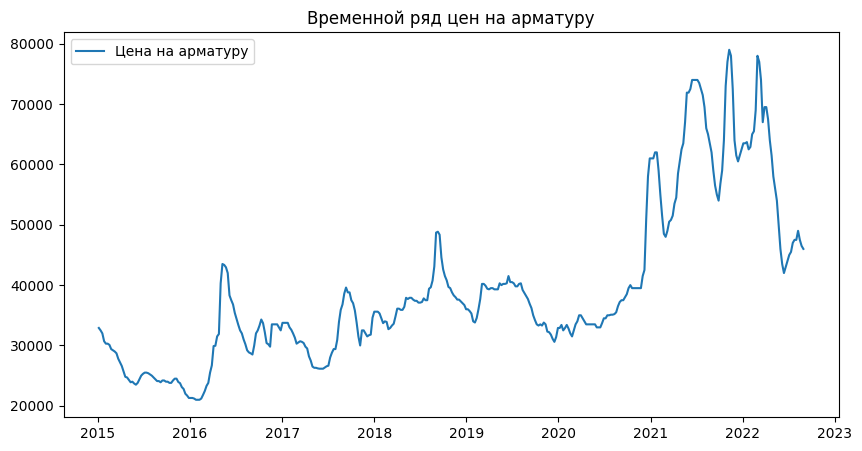

ADF Statistic: -1.9258699893713453
p-value: 0.3199906102569917
Ряд нестационарный (p > 0.05), требуется дифференцирование


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Загружаем данные
df = pd.read_excel("data/train.xlsx", parse_dates=["dt"], index_col="dt")
price_series = df["Цена на арматуру"]

# Визуализация временного ряда
plt.figure(figsize=(10,5))
plt.plot(price_series, label="Цена на арматуру")
plt.title("Временной ряд цен на арматуру")
plt.legend()
plt.show()

# ADF Test
adf_test = adfuller(price_series)
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")
if adf_test[1] < 0.05:
    print("Ряд стационарный (p < 0.05)")
else:
    print("Ряд нестационарный (p > 0.05), требуется дифференцирование")


In [38]:
df["diff"] = df["Цена на арматуру"].diff()
df.dropna(inplace=True)

# Повторный тест Дики-Фуллера
adf_test = adfuller(df["diff"])
print(f"ADF Statistic после дифференцирования: {adf_test[0]}")
print(f"p-value после дифференцирования: {adf_test[1]}")


ADF Statistic после дифференцирования: -7.7060615041152065
p-value после дифференцирования: 1.3006938373810178e-11


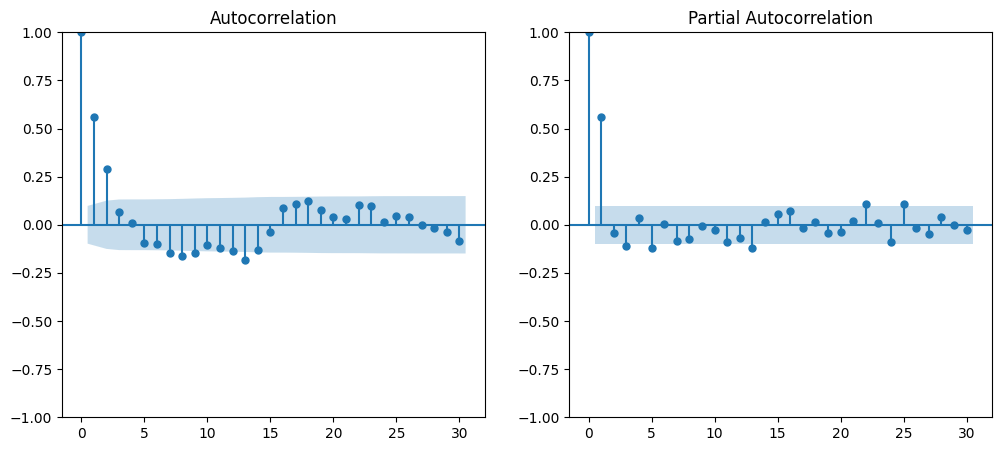

In [39]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,5))
plt.subplot(121)
plot_acf(df["diff"], lags=30, ax=plt.gca())  # Определяем q
plt.subplot(122)
plot_pacf(df["diff"], lags=30, ax=plt.gca())  # Определяем p
plt.show()


In [40]:
from pmdarima import auto_arima

model = auto_arima(df["Цена на арматуру"], seasonal=False, stepwise=True, trace=True)
print(model.summary())


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprec

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6966.221, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7054.267, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6963.242, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6976.679, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7052.427, Time=0.03 sec


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6966.677, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6966.522, Time=0.08 sec


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6958.904, Time=0.41 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6966.553, Time=0.19 sec


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6965.840, Time=0.13 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=6966.757, Time=0.09 sec


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6960.058, Time=0.48 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=6958.002, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6964.436, Time=0.06 sec


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0]             : AIC=6964.578, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=6964.519, Time=0.12 sec


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=6964.194, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=6961.230, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=6963.825, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=6964.683, Time=0.06 sec


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0]             : AIC=6957.880, Time=0.32 sec


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[0]             : AIC=6960.668, Time=0.33 sec


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=0.45 sec


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0]             : AIC=6960.056, Time=0.22 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=6966.470, Time=0.15 sec


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,0)[0]             : AIC=6960.063, Time=0.53 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0]          
Total fit time: 4.551 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  399
Model:               SARIMAX(3, 1, 2)   Log Likelihood               -3472.940
Date:                Mon, 24 Mar 2025   AIC                           6957.880
Time:                        23:51:46   BIC                           6981.799
Sample:                    01-12-2015   HQIC                          6967.354
                         - 08-29-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4143      0.157      2.632      0.008       0.106 

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Use

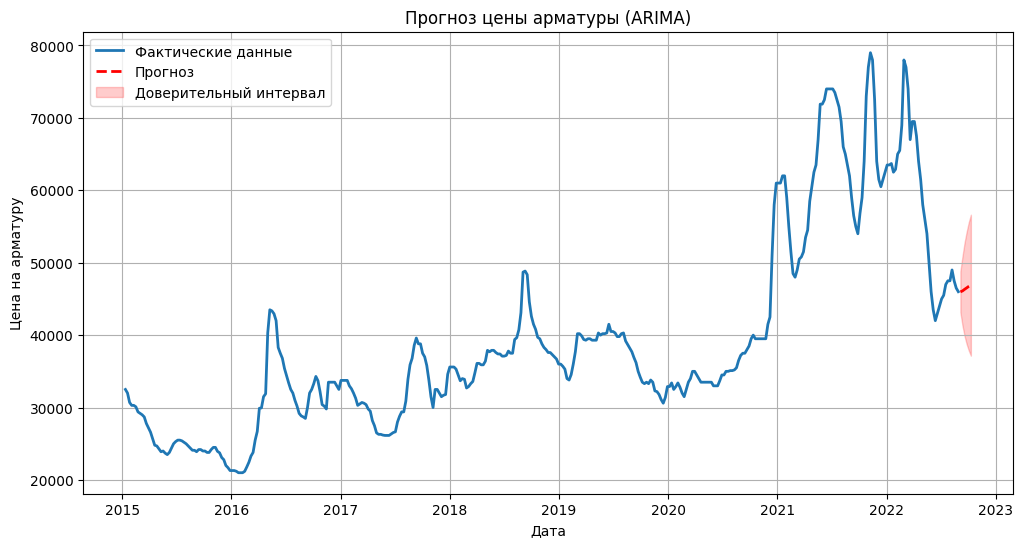

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Задаем параметры ARIMA
p, d, q = 3, 1, 2  

# Обучение модели
model = ARIMA(df["Цена на арматуру"], order=(p, d, q))
model_fit = model.fit()

# Прогноз на 6 недель вперед
future_steps = 6
forecast = model_fit.get_forecast(steps=future_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()  # Доверительный интервал

# Создаем даты для прогноза
forecast_index = pd.date_range(start=df.index[-1], periods=future_steps+1, freq="W-MON")[1:]

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Цена на арматуру"], label="Фактические данные", linewidth=2)
plt.plot(forecast_index, forecast_mean, "r--", label="Прогноз", linewidth=2)
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color="red", alpha=0.2, label="Доверительный интервал")

plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Прогноз цены арматуры (ARIMA)")
plt.legend()
plt.grid(True)
plt.show()


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Use

Mean Squared Error (MSE): 301429004.05379546
Root Mean Squared Error (RMSE): 17361.710861945474
Mean Absolute Error (MAE): 14426.82152876663


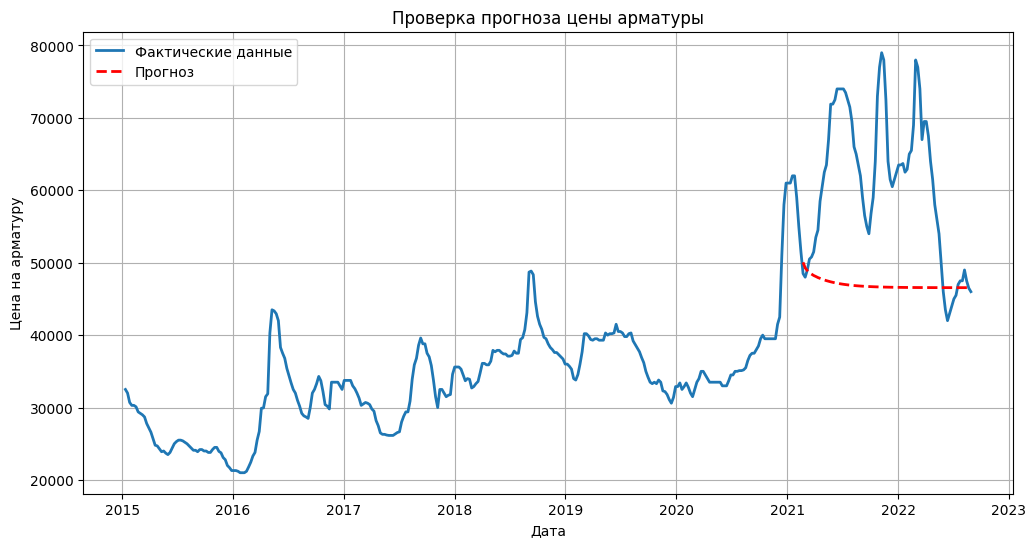

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Разделим данные на тренировочные и тестовые
train_size = int(len(df) * 0.8)  # 80% данных на тренировку, 20% на тест
train, test = df["Цена на арматуру"][:train_size], df["Цена на арматуру"][train_size:]

# Обучаем модель на тренировочных данных
model = ARIMA(train, order=(3, 1, 2))
model_fit = model.fit()

# Прогнозируем на тестовых данных
forecast = model_fit.forecast(steps=len(test))

# Вычисляем метрики точности
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, forecast)

# Выводим метрики
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

# Визуализируем
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Цена на арматуру"], label="Фактические данные", linewidth=2)
plt.plot(test.index, forecast, "r--", label="Прогноз", linewidth=2)
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Проверка прогноза цены арматуры")
plt.legend()
plt.grid(True)
plt.show()


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


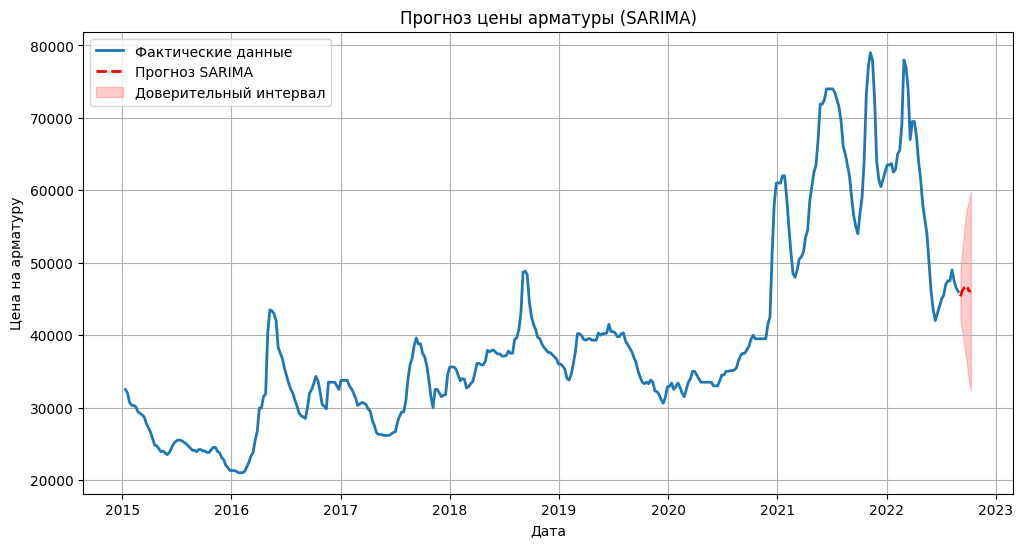

                                      SARIMAX Results                                       
Dep. Variable:                     Цена на арматуру   No. Observations:                  399
Model:             SARIMAX(3, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -3263.170
Date:                              Mon, 24 Mar 2025   AIC                           6542.341
Time:                                      23:51:50   BIC                           6573.670
Sample:                                  01-12-2015   HQIC                          6554.784
                                       - 08-29-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.3468      0.124     18.901      0.000       2.103       2.590
ar.L2         -1.85

In [43]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Указываем сезонный период (например, 52 недели, если данные годовые, или 12, если данные месячные)
seasonal_period = 12  # Настроить по вашему случаю

# Обучаем модель SARIMA (p, d, q) для тренда и (P, D, Q, m) для сезонности
sarima_model = SARIMAX(df["Цена на арматуру"], 
                       order=(3, 1, 2),  # p, d, q для тренда
                       seasonal_order=(1, 1, 1, seasonal_period),  # P, D, Q, m для сезонности
                       enforce_stationarity=False,  # Не ограничиваем стационарность
                       enforce_invertibility=False)  # Не ограничиваем инвертируемость

# Обучаем модель
sarima_fit = sarima_model.fit(disp=True)

# Прогнозируем на 6 недель вперед
future_steps = 6
forecast_sarima = sarima_fit.get_forecast(steps=future_steps)
forecast_sarima_mean = forecast_sarima.predicted_mean
forecast_sarima_ci = forecast_sarima.conf_int()  # Доверительный интервал

# Создаем даты для прогноза
forecast_sarima_index = pd.date_range(start=df.index[-1], periods=future_steps+1, freq="W-MON")[1:]

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Цена на арматуру"], label="Фактические данные", linewidth=2)
plt.plot(forecast_sarima_index, forecast_sarima_mean, "r--", label="Прогноз SARIMA", linewidth=2)
plt.fill_between(forecast_sarima_index, forecast_sarima_ci.iloc[:, 0], forecast_sarima_ci.iloc[:, 1], color="red", alpha=0.2, label="Доверительный интервал")

plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Прогноз цены арматуры (SARIMA)")
plt.legend()
plt.grid(True)
plt.show()

# Выводим параметры модели
print(sarima_fit.summary())


In [54]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor, early_stopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y = y[X.index]

X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)
model0 = LGBMRegressor(n_estimators=5000, max_depth=7, learning_rate=0.03,
                       objective='mae', metric='mae',
                       random_state=42, verbose=100)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=False
)
model0.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],
           callbacks=[early_stopping(stopping_rounds=100)])

y_pred = model0.predict(X_valid)

y_pred_holdout = model0.predict(X_holdout)

mae = mean_absolute_error(y_valid, y_pred)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
r2 = r2_score(y_valid, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")



[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.031250
[LightGBM] [Debug] init for col-wise cost 0.000002 seconds, init for row-wise cost 0.000425 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 220
[LightGBM] [Info] Number of data points in the train set: 272, number of used features: 6
[LightGBM] [Info] Start training from score 36850.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 2
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 2
[L

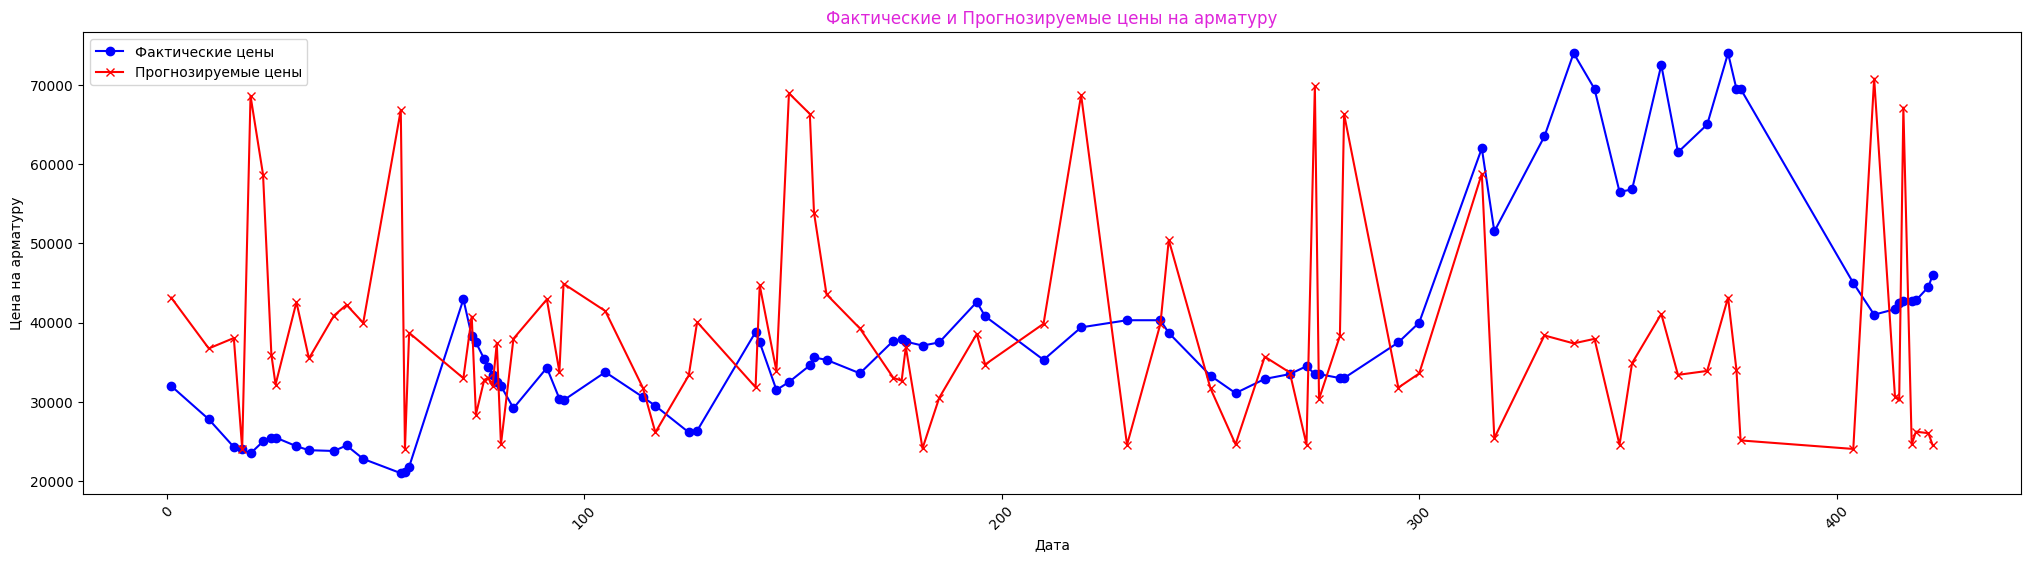

In [46]:
y_holdout = y_holdout.sort_index()
y_pred_holdout = pd.Series(y_pred_holdout, index=y_holdout.index).sort_index()

plt.figure(figsize=(25, 6))
plt.plot(y_holdout.index, y_holdout.values, label="Фактические цены", color='blue', marker='o')
plt.plot(y_holdout.index, y_pred_holdout, label="Прогнозируемые цены", color='red', marker='x')

plt.legend()
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Фактические и Прогнозируемые цены на арматуру", color='#de25da')
plt.xticks(rotation=45)
plt.show()

In [47]:
import joblib
joblib.dump(model0, "LGBMRegressor.pkl")

['LGBMRegressor.pkl']

In [48]:
#column = 'Цена на арматуру'
#plt.figure(figsize=(8, 5))
#sns.histplot(df[column], bins=30, kde=True)
#plt.title("Распределение цен на арматуру")
#plt.xlabel("Цена")
#plt.ylabel("Частота")
#plt.show()

In [49]:
#print(df.columns)  # Выведет все столбцы DataFrame

In [50]:
#df['dt'] = pd.to_datetime(df['dt'])
#df.set_index('dt', inplace=True)
#plt.figure(figsize=(12, 6))
#plt.plot(df.index, df['Цена на арматуру'], label='Цена на арматуру', color='b')
#plt.title('Динамика цен на арматуру')
#plt.xlabel('Дата')
#plt.ylabel('Цена')
#plt.legend()
#plt.grid()
#plt.show()

In [51]:
#fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 40))
#decompose = seasonal_decompose(df[['Цена на арматуру']])

#ax[0].set_title('Оригинал')
#ax[1].set_title('Тренд')
#ax[2].set_title('Сезонность')
#ax[3].set_title('Остаток')

#decompose.observed.plot(ax=ax[0])
#decompose.trend.plot(ax=ax[1])
#decompose.seasonal.plot(ax=ax[2])
#decompose.resid.plot(ax=ax[3]);

In [52]:
#print(df.columns)

In [53]:
#df['month'] = df.index.month
#plt.figure(figsize=(7, 5))
#sns.lineplot(x=df['month'], y=df['Цена на арматуру'], errorbar=None)
#plt.xlabel('Месяц')  # Подпись оси X
#plt.ylabel('Цена на арматуру')  # Подпись оси Y (возможно, здесь ошибка, так как строится цена на арматуру)
#plt.title('Сезонные изменения цен')  # Заголовок графика
#plt.xticks(range(1, 13), labels=[
    #'Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн',
    #'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек']
#plt.grid(True)
#plt.show()